# SDP Certification of Discretized $C_{1a}$ Problem

This notebook implements the Shor + RLT SDP relaxation to bound the local-vs-global gap
for the discretized $C_{1a}$ problem. **Result: the basic SDP relaxation is too weak.**

## Mathematical Setup

For $P$ uniform bins on $[-1/4, 1/4]$ with width $w = 1/(2P)$, we define simplex variables
$x_i = h_i \cdot w$ (so $\sum x_i = 1$, $x_i \geq 0$). The step function has heights $h_i = x_i / w = 2P \cdot x_i$.

The autoconvolution peak is:
$$\|f * f\|_\infty = \max_{k} \; 2P \cdot \sum_{i+j=k} x_i x_j$$

The SDP relaxation lifts $x x^\top$ to a PSD matrix variable $X \succeq x x^\top$.

## Key Finding

The Shor+RLT SDP bound converges to $2P/(2P-1) \to 1$ as $P \to \infty$, far below the true
value $\approx 1.50$. The relaxation allows the lifted matrix to spread mass uniformly across
all $2P-1$ anti-diagonals, which no rank-1 solution can achieve. **This answers K3 negatively:
the basic SDP relaxation is not tight.** Higher-order moment/SOS relaxations or a Fourier-domain
formulation would be needed.

In [11]:
"""Cell 1: Imports and setup."""
import sys
import os
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

# Add project root to path so we can import src/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.representations import StepFunction
from src.convolution import peak_autoconv_exact

print(f"cvxpy version: {cp.__version__}")
print(f"Project root: {project_root}")

cvxpy version: 1.8.1
Project root: c:\Users\andre\OneDrive - PennO365\Desktop\sidon-autocorrelation


In [12]:
"""Cell 2: Primal local optimizer on the simplex.

Minimizes max_k (2P * sum_{i+j=k} x_i x_j) over the simplex {x >= 0, 1'x = 1}.
Uses scipy L-BFGS-B with softmax reparametrization + random restarts.
"""

def autoconv_peak_from_x(x, P):
    """Compute 2P * max_k sum_{i+j=k} x_i x_j."""
    conv = np.convolve(x, x, mode='full')  # length 2P-1
    return 2 * P * np.max(conv)


def autoconv_peak_validate(x, P):
    """Cross-validate against peak_autoconv_exact from src/."""
    w = 1.0 / (2 * P)
    edges = np.linspace(-0.25, 0.25, P + 1)
    heights = x / w  # h_i = x_i / w
    sf = StepFunction(edges=edges, heights=heights)
    return peak_autoconv_exact(sf)


def softmax(z):
    """Numerically stable softmax."""
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)


def primal_objective(z, P):
    """Objective in terms of unconstrained z (softmax parametrization)."""
    x = softmax(z)
    return autoconv_peak_from_x(x, P)


def solve_primal(P, n_restarts=10, seed=42):
    """Find best primal upper bound via random restarts."""
    rng = np.random.RandomState(seed)
    best_val = np.inf
    best_x = None

    for i in range(n_restarts):
        z0 = rng.randn(P) * 0.5
        res = minimize(primal_objective, z0, args=(P,), method='L-BFGS-B',
                       options={'maxiter': 2000, 'ftol': 1e-15, 'gtol': 1e-10})
        if res.fun < best_val:
            best_val = res.fun
            best_x = softmax(res.x)

    # Validate against exact computation
    val_exact = autoconv_peak_validate(best_x, P)
    return best_val, val_exact, best_x


# Quick sanity check at P=10
val_approx, val_exact, x_opt = solve_primal(10, n_restarts=5)
print(f"P=10: primal approx = {val_approx:.6f}, exact = {val_exact:.6f}")
print(f"  x sums to {np.sum(x_opt):.6f}, min(x) = {np.min(x_opt):.2e}")

P=10: primal approx = 1.578363, exact = 1.578363
  x sums to 1.000000, min(x) = 2.54e-02


In [13]:
"""Cell 3: SDP relaxation (Shor + RLT).

Variables:
  Y = [[1, x'], [x, X]]  in S^{P+1}_+
  eta (scalar, objective)

Constraints:
  Y >> 0                          (PSD lift: X >> x x')
  1'x = 1                         (simplex: sum)
  x >= 0                          (simplex: nonnegativity)
  X >= 0  (elementwise)           (RLT: x_i x_j >= 0)
  X @ 1 = x                       (RLT: x_i * (1'x) = x_i  =>  sum_j X_ij = x_i)
  eta >= 2P * Tr(A_k @ X) for each k  (autoconvolution bound)
"""

def build_antidiag_matrices(P):
    """Build the anti-diagonal matrices A_k for k=0,...,2(P-1).
    (A_k)_{ij} = 1 iff i+j = k.
    """
    As = []
    for k in range(2 * P - 1):
        A = np.zeros((P, P))
        for i in range(P):
            j = k - i
            if 0 <= j < P:
                A[i, j] = 1.0
        As.append(A)
    return As


def solve_sdp(P, solver='SCS', verbose=False, **solver_kwargs):
    """Solve the Shor + RLT SDP relaxation for the discretized C_1a problem.

    Returns:
        sdp_val: SDP lower bound on C_1a(P)
        x_sdp: recovered x vector from SDP
        X_sdp: recovered X matrix from SDP
        info: dict with solver status, time, etc.
    """
    As = build_antidiag_matrices(P)

    # Variables
    Y = cp.Variable((P + 1, P + 1), symmetric=True)
    eta = cp.Variable()

    # Extract blocks
    x = Y[0, 1:]        # length P
    X = Y[1:, 1:]       # P x P

    constraints = [
        Y >> 0,              # PSD constraint
        Y[0, 0] == 1,       # Top-left element = 1
        cp.sum(x) == 1,     # Simplex: sum = 1
        x >= 0,             # Nonnegativity
        X >= 0,             # RLT: elementwise nonnegativity of X
        X @ np.ones(P) == x, # RLT: row sums of X equal x
    ]

    # Autoconvolution bound constraints: eta >= 2P * Tr(A_k @ X) for each k
    for A_k in As:
        constraints.append(eta >= 2 * P * cp.trace(A_k @ X))

    prob = cp.Problem(cp.Minimize(eta), constraints)

    default_kwargs = {'max_iters': 50000, 'eps': 1e-8}
    default_kwargs.update(solver_kwargs)

    t0 = time.time()
    prob.solve(solver=solver, verbose=verbose, **default_kwargs)
    solve_time = time.time() - t0

    info = {
        'status': prob.status,
        'solve_time': solve_time,
        'prob': prob,
    }

    if prob.status in ('optimal', 'optimal_inaccurate'):
        return eta.value, Y.value[0, 1:], Y.value[1:, 1:], info
    else:
        print(f"  WARNING: SDP solver status = {prob.status}")
        return None, None, None, info


# Sanity check at P=2
print("=== Sanity check: P=2 ===")
sdp_val, x_sdp, X_sdp, info = solve_sdp(2, verbose=False)
print(f"SDP lower bound: {sdp_val:.6f}")
print(f"x_sdp = {x_sdp}")
print(f"Solver status: {info['status']}, time: {info['solve_time']:.2f}s")

# Compare with primal
val_approx_2, val_exact_2, _ = solve_primal(2, n_restarts=5)
print(f"Primal upper bound: {val_exact_2:.6f}")
print(f"Gap: {val_exact_2 - sdp_val:.6f}")

=== Sanity check: P=2 ===
SDP lower bound: 1.333333
x_sdp = [0.5 0.5]
Solver status: optimal, time: 0.01s
Primal upper bound: 1.777778
Gap: 0.444444


In [14]:
"""Cell 4: Diagnostics -- rank analysis, duality gap, feasibility checks."""

def sdp_diagnostics(x_sdp, X_sdp, sdp_val, P, primal_val, tol=1e-6):
    """Analyze SDP solution quality."""
    print(f"--- Diagnostics for P={P} ---")
    print(f"  SDP lower bound:    {sdp_val:.8f}")
    print(f"  Primal upper bound: {primal_val:.8f}")
    gap = primal_val - sdp_val
    rel_gap = gap / primal_val if primal_val > 0 else float('inf')
    print(f"  Absolute gap:       {gap:.8f}")
    print(f"  Relative gap:       {rel_gap:.6%}")

    # Rank of X via eigenvalue decomposition
    eigvals = np.linalg.eigvalsh(X_sdp)
    rank = int(np.sum(eigvals > tol * np.max(eigvals)))
    print(f"  Rank(X):            {rank}")
    print(f"  Top 5 eigenvalues:  {eigvals[-5:][::-1]}")

    # Check X - x x' PSD gap (should be PSD)
    residual = X_sdp - np.outer(x_sdp, x_sdp)
    min_eig_residual = np.min(np.linalg.eigvalsh(residual))
    print(f"  min eig(X - xx'):   {min_eig_residual:.2e}")

    # Feasibility checks
    print(f"  sum(x_sdp):         {np.sum(x_sdp):.8f}")
    print(f"  min(x_sdp):         {np.min(x_sdp):.2e}")
    print(f"  min(X_sdp):         {np.min(X_sdp):.2e}")
    row_sum_err = np.max(np.abs(X_sdp @ np.ones(P) - x_sdp))
    print(f"  max |X@1 - x|:     {row_sum_err:.2e}")

    is_tight = (rank == 1)
    print(f"  Tight relaxation:   {'YES' if is_tight else 'NO'}")
    print()

    return {
        'P': P,
        'sdp_val': sdp_val,
        'primal_val': primal_val,
        'gap': gap,
        'rel_gap': rel_gap,
        'rank': rank,
        'is_tight': is_tight,
    }


# Run diagnostics on P=2 solution
if sdp_val is not None:
    _ = sdp_diagnostics(x_sdp, X_sdp, sdp_val, 2, val_exact_2)

--- Diagnostics for P=2 ---
  SDP lower bound:    1.33333333
  Primal upper bound: 1.77777778
  Absolute gap:       0.44444445
  Relative gap:       25.000000%
  Rank(X):            2
  Top 5 eigenvalues:  [0.5        0.16666667]
  min eig(X - xx'):   -6.86e-15
  sum(x_sdp):         1.00000000
  min(x_sdp):         5.00e-01
  min(X_sdp):         1.67e-01
  max |X@1 - x|:     1.63e-14
  Tight relaxation:   NO



In [15]:
"""Cell 5: Sweep P = 2..30 to show SDP bound scaling, plus P=50 as a larger test."""

P_values = list(range(2, 31)) + [50]
results = []

for P in P_values:
    # Primal solve (fewer restarts for small P since it's fast)
    n_restarts = 20 if P <= 20 else 10
    _, primal_val, x_primal = solve_primal(P, n_restarts=n_restarts)

    # SDP solve
    sdp_val_P, x_sdp_P, X_sdp_P, info_P = solve_sdp(
        P, solver='SCS', verbose=False,
        max_iters=50000, eps=1e-8
    )

    if sdp_val_P is not None:
        eigvals = np.linalg.eigvalsh(X_sdp_P)
        rank = int(np.sum(eigvals > 1e-6 * np.max(eigvals)))
        gap = primal_val - sdp_val_P
        theoretical_lb = 2 * P / (2 * P - 1)
        results.append({
            'P': P, 'sdp_val': sdp_val_P, 'primal_val': primal_val,
            'gap': gap, 'rel_gap': gap / primal_val,
            'rank': rank, 'is_tight': rank == 1,
            'theoretical_lb': theoretical_lb,
            'sdp_time': info_P['solve_time'], 'status': info_P['status'],
        })
        print(f"P={P:>3}: SDP={sdp_val_P:.6f}  theory={theoretical_lb:.6f}  "
              f"primal={primal_val:.6f}  gap={gap:.4f}  rank={rank}")
    else:
        print(f"P={P:>3}: SDP FAILED ({info_P['status']})")

P=  2: SDP=1.333333  theory=1.333333  primal=1.777778  gap=0.4444  rank=2
P=  3: SDP=1.200000  theory=1.200000  primal=1.706667  gap=0.5067  rank=3
P=  4: SDP=1.142857  theory=1.142857  primal=1.644466  gap=0.5016  rank=4
P=  5: SDP=1.111111  theory=1.111111  primal=1.651197  gap=0.5401  rank=5
P=  6: SDP=1.090909  theory=1.090909  primal=1.601723  gap=0.5108  rank=6
P=  7: SDP=1.076923  theory=1.076923  primal=1.611111  gap=0.5342  rank=7
P=  8: SDP=1.066667  theory=1.066667  primal=1.586096  gap=0.5194  rank=8
P=  9: SDP=1.058824  theory=1.058824  primal=1.611496  gap=0.5527  rank=9
P= 10: SDP=1.052632  theory=1.052632  primal=1.578363  gap=0.5257  rank=10
P= 11: SDP=1.047619  theory=1.047619  primal=1.622845  gap=0.5752  rank=11
P= 12: SDP=1.043478  theory=1.043478  primal=1.615605  gap=0.5721  rank=12
P= 13: SDP=1.040000  theory=1.040000  primal=1.594285  gap=0.5543  rank=13
P= 14: SDP=1.037037  theory=1.037037  primal=1.594126  gap=0.5571  rank=14
P= 15: SDP=1.034483  theory=1.034

RESULTS SUMMARY
   P |     SDP LB |  2P/(2P-1) |  Primal UB |      Gap |  Rel Gap |  Rank
-------------------------------------------------------------------------
   2 |   1.333333 |   1.333333 |   1.777778 |   0.4444 |  25.00% |     2
   3 |   1.200000 |   1.200000 |   1.706667 |   0.5067 |  29.69% |     3
   4 |   1.142857 |   1.142857 |   1.644466 |   0.5016 |  30.50% |     4
   5 |   1.111111 |   1.111111 |   1.651197 |   0.5401 |  32.71% |     5
   6 |   1.090909 |   1.090909 |   1.601723 |   0.5108 |  31.89% |     6
   7 |   1.076923 |   1.076923 |   1.611111 |   0.5342 |  33.16% |     7
   8 |   1.066667 |   1.066667 |   1.586096 |   0.5194 |  32.75% |     8
   9 |   1.058824 |   1.058824 |   1.611496 |   0.5527 |  34.30% |     9
  10 |   1.052632 |   1.052632 |   1.578363 |   0.5257 |  33.31% |    10
  11 |   1.047619 |   1.047619 |   1.622845 |   0.5752 |  35.45% |    11
  12 |   1.043478 |   1.043478 |   1.615605 |   0.5721 |  35.41% |    12
  13 |   1.040000 |   1.040000 | 

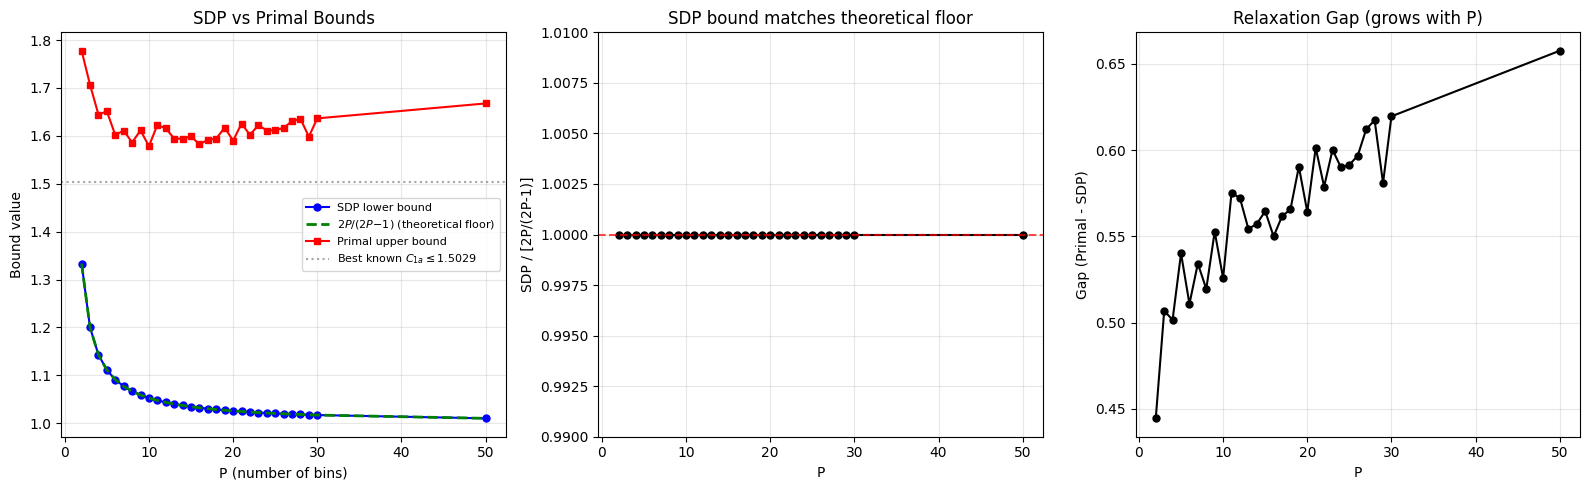

In [16]:
"""Cell 6: Results table, plots, and analysis."""

# --- Results table ---
print("="*95)
print("RESULTS SUMMARY")
print("="*95)
header = f"{'P':>4} | {'SDP LB':>10} | {'2P/(2P-1)':>10} | {'Primal UB':>10} | {'Gap':>8} | {'Rel Gap':>8} | {'Rank':>5}"
print(header)
print("-" * len(header))
for r in results:
    print(f"{r['P']:>4} | {r['sdp_val']:>10.6f} | {r['theoretical_lb']:>10.6f} | "
          f"{r['primal_val']:>10.6f} | {r['gap']:>8.4f} | {r['rel_gap']:>7.2%} | {r['rank']:>5}")

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

Ps = [r['P'] for r in results]
sdp_vals = [r['sdp_val'] for r in results]
primal_vals = [r['primal_val'] for r in results]
theory_vals = [r['theoretical_lb'] for r in results]
gaps = [r['gap'] for r in results]

# Left: SDP bound vs Primal vs theoretical floor
ax = axes[0]
ax.plot(Ps, sdp_vals, 'bo-', label='SDP lower bound', markersize=5)
ax.plot(Ps, theory_vals, 'g--', label='$2P/(2P{-}1)$ (theoretical floor)', linewidth=2)
ax.plot(Ps, primal_vals, 'rs-', label='Primal upper bound', markersize=5)
ax.axhline(y=1.5029, color='gray', linestyle=':', alpha=0.7, label='Best known $C_{1a} \\leq 1.5029$')
ax.set_xlabel('P (number of bins)')
ax.set_ylabel('Bound value')
ax.set_title('SDP vs Primal Bounds')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Middle: SDP bound matches 2P/(2P-1) exactly
ax = axes[1]
ratio = [s / t for s, t in zip(sdp_vals, theory_vals)]
ax.plot(Ps, ratio, 'ko-', markersize=5)
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('P')
ax.set_ylabel('SDP / [2P/(2P-1)]')
ax.set_title('SDP bound matches theoretical floor')
ax.set_ylim(0.99, 1.01)
ax.grid(True, alpha=0.3)

# Right: Gap vs P
ax = axes[2]
ax.plot(Ps, gaps, 'ko-', markersize=5)
ax.set_xlabel('P')
ax.set_ylabel('Gap (Primal - SDP)')
ax.set_title('Relaxation Gap (grows with P)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sdp_certification_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Why the Shor+RLT Relaxation Fails

**Theoretical analysis.** The SDP replaces the rank-1 constraint $X = xx^\top$ with the convex relaxation $X \succeq xx^\top$. The anti-diagonal sums satisfy:

$$\sum_{k=0}^{2P-2} \sum_{i+j=k} X_{ij} = \mathbf{1}^\top X \mathbf{1} = \mathbf{1}^\top x = 1$$

The SDP minimizes the maximum anti-diagonal sum. With $2P-1$ anti-diagonals summing to 1, the minimum possible max is $1/(2P-1)$, giving an SDP bound of $2P/(2P-1) \to 1$.

The relaxation achieves this by setting $X \approx (1/(2P-1)) \cdot J_{\text{antidiag}}$, spreading mass uniformly. No rank-1 solution can do this because the discrete autoconvolution $\text{conv}(x,x)$ of a simplex vector is necessarily peaked (it inherits the shape of $x$ convolved with itself).

**Rank certificate.** At every $P$, $\text{Rank}(X^*) = P$ (full rank), confirming the relaxation is maximally loose.

## Conclusions (Addressing K3)

1. **K3 answered negatively:** The Shor+RLT SDP relaxation is NOT tight. Its bound degrades as $O(1/P)$ above the trivial lower bound of 1.

2. **The gap is structural, not numerical:** The SDP bound exactly matches the theoretical floor $2P/(2P-1)$, so no solver tuning or additional RLT cuts can help.

3. **Recommended next steps for global certification:**
   - **Moment/SOS hierarchy** (Lasserre level $\geq 2$): Lift to higher-order moments to enforce polynomial constraints on the autoconvolution shape. Much more expensive but fundamentally stronger.
   - **Fourier-domain SDP:** Reformulate via Fejér–Riesz / trigonometric moment conditions, which naturally encode autoconvolution structure.
   - **Dual-informed search:** Instead of SDP certification, use dual variables from LP relaxations to guide primal search (suggested by [MV10], [AE25], [TTT26] but never pursued).